In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
class GaussianClass:
    def __init__(self, train_size, test_size, dim, center, std):
        self.Xtr = np.array([np.random.normal(loc=center, scale=std, size=dim) for _ in range(train_size)])
        self.Xte = np.array([np.random.normal(loc=center, scale=std, size=dim) for _ in range(test_size)])
        self.Xtr_enc = None
        self.Xte_enc = None
        
    def encode(self, encoder):
        self.Xtr_enc = encoder.encode_list(self.Xtr)
        self.Xte_enc = encoder.encode_list(self.Xte)


class Dataset:
    def __init__(self, classes):
        self.classes = classes   
    
    def get_class_hypervectors(self, encoder, agg="bundle", threshold=500):
        for cls in self.classes:
            cls.encode(encoder)
        
        if agg == "bundle":
            class_hvs = [np.sum(cls.Xtr_enc, axis=0) for cls in self.classes]
        elif agg == "retrain":
            class_hvs = [np.sum(cls.Xtr_enc, axis=0) for cls in self.classes]
            
            for _ in range(threshold):
                perfect = True
                for i, cls in enumerate(self.classes):
                    for phi_x in cls.Xtr_enc:
                        sims = [encoder.sim(phi_x, phi_c) for phi_c in class_hvs]
                        pred_cls = np.argmax(sims)
                        if i != pred_cls:
                            class_hvs[i] += (1 - sims[i]) * phi_x
                            class_hvs[pred_cls] -= sims[pred_cls] * phi_x
                            perfect = False
                if perfect: break
        
        return class_hvs
    
class Encoder:
    def encode(self, x):
        raise NotImplementedError
    
    def encode_list(self, X):
        encoded_hvs = []
        for x in X:
            encoded_hvs.append(self.encode(x))
        return np.array(encoded_hvs)
    
    def get_lipschitz_constant(self, out=True):
        raise NotImplementedError

    def inner(self, x, y):
        raise NotImplementedError
        
    def sim(self, x, y):
        inner = self.inner(x, y)
        norm = np.sqrt(self.inner(x, x) * self.inner(y, y))
        return inner if inner == 0 else inner / norm

class FHRREncoder(Encoder):
    def __init__(self, in_dim, out_dim, kernel="rbf"):
        super().__init__()
        self.out_dim = out_dim
        
        if kernel == 'rbf':
            self.M = np.random.normal(size=(out_dim, in_dim))
        elif kernel == 'sinc':
            self.M = np.random.rand(out_dim, in_dim)
        
    def encode(self, x):
        return np.exp(1j * np.tensordot(self.M, x, axes=1))
    
    def get_lipschitz_constant(self, out=False):
        D = self.out_dim
        r = 2

        xs = np.linspace(-r, r, 100)
        ys = np.linspace(-r, r, 100)
        x, y = np.meshgrid(xs, ys)
        phi_0 = self.encode(np.array([0, 0]))
        xys_enc = self.encode(np.stack([x, y], axis=0))
        betas = np.sqrt(2 * (D - self.inner(phi_0, xys_enc))) / np.linalg.norm(np.stack([x, y]), axis=0)

        if out:
            fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
            ax.plot_surface(x, y, betas)

        return np.max(betas)
    
    def get_lipschitz_constant2(self, phi_c1, phi_c2, out=False):
        D = self.out_dim
        N = 100

        xs = np.linspace(-5, 15, N)
        ys = np.linspace(-5, 15, N)
        x, y = np.meshgrid(xs, ys)
        XY = np.stack([x, y])
        v = phi_c1 - phi_c2
        v = np.tile(v, (N, N, 1)).T
        
        def f(XY):
            Mx = np.tensordot(self.M, XY, axes=1)
            print('Mx.shape', Mx.shape)
            z = -v.real * np.sin(Mx) + v.imag * np.cos(Mx)
            print('z.shape', z.shape)
            print('self.M.T', self.M.T.shape)
            print(np.tensordot(self.M.T, z, axes=1).shape)
            return np.linalg.norm(np.tensordot(self.M.T, z, axes=1), axis=0)
        sims = f(XY)
        print('sims.shape', sims.shape)
        if out:
            fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
            ax.plot_surface(x, y, sims, rstride=1, cstride=1,
                            cmap='viridis', edgecolor='none')
        return np.max(np.abs(sims))
    
    def set_lipschitz_constant(self, phi_c1, phi_c2):
        phi_diff = phi_c1 - phi_c2
        self.L1 = np.sqrt(self.inner(phi_diff, phi_diff)) * self.get_lipschitz_constant()
        self.L2 = self.get_lipschitz_constant2(phi_c1, phi_c2)

    def inner(self, x, y):
        z = np.tensordot(x, np.conjugate(y), axes=1)
        return z.real
    
def get_eps(encoder, q, phi_c1, phi_c2, method=0):
    phi_diff = phi_c1 - phi_c2
    r_q = np.abs(encoder.inner(phi_diff, encoder.encode(q)))
    if method == 0:
        L = encoder.L1
    else:
        L = encoder.L2
    return r_q / L

Mx.shape (1000, 100, 100)
z.shape (1000, 100, 100)
self.M.T (2, 1000)
(2, 100, 100)
sims.shape (100, 100)
Mx.shape (1000, 100, 100)
z.shape (1000, 100, 100)
self.M.T (2, 1000)
(2, 100, 100)
sims.shape (100, 100)


2682.7159328912767

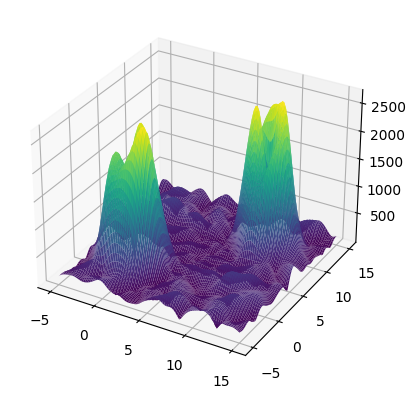

In [11]:
in_dim = 2
out_dim = 1000
train_size = 10
test_size = 10

c1 = GaussianClass(train_size, test_size, in_dim, np.array([0, 0]), 1)
c2 = GaussianClass(train_size, test_size, in_dim, np.array([10, 10]), 1)
dataset = Dataset([c1, c2])

encoder = FHRREncoder(in_dim, out_dim, kernel='rbf')
phis = dataset.get_class_hypervectors(encoder, agg='bundle')
phi_c1 = phis[0]
phi_c2 = phis[1]
encoder.set_lipschitz_constant(phi_c1, phi_c2)

encoder.get_lipschitz_constant2(phi_c1, phi_c2, out=True)

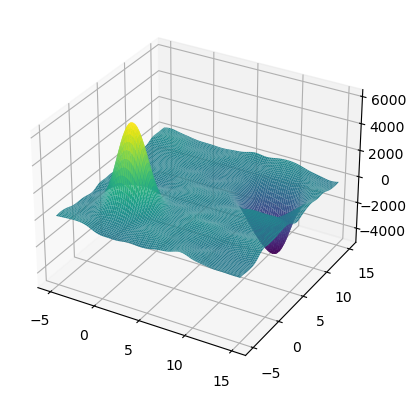

In [4]:
xs = np.linspace(-5, 15, 100)
ys = np.linspace(-5, 15, 100)
x, y = np.meshgrid(xs, ys)

phi_0 = encoder.encode(np.array([0, 0]))
xys_enc = encoder.encode(np.stack([x, y], axis=0))
zs = encoder.inner(phi_c1 - phi_c2, xys_enc)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot_surface(x, y, zs, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

In [5]:
def sat_cond_within_radius(x_ctr, r, xy, zs, cond):
    d, N, M = xy.shape
    x_aug = np.tile(x_ctr, (M, N, 1)).T
    dists = np.linalg.norm(xy - x_aug, axis=0)
    return np.all(cond(zs[dists <= r]))

def get_actual_eps(encoder, phi_c1, phi_c2, x_ctr, x_grid, y_grid, zs, init_r=1, threshold=100, tol=1e-4):
    phi_x = encoder.encode(x_ctr)
    r_x = (phi_c1 - phi_c2) @ phi_x
    
    if r_x >= 0:
        cond = lambda x: x >= 0
    else:
        cond = lambda x: x < 0
    
    xy = np.stack([x_grid, y_grid])
    r_l = 0
    r_h = init_r
    for _ in range(threshold):
        if sat_cond_within_radius(x_ctr, r_h, xy, zs, cond):
            r_l, r_h = r_h, r_h * 2
        else:
            r_h = r_l + (r_h - r_l) / 2
        if r_h - r_l <= tol:
            break
    return r_h

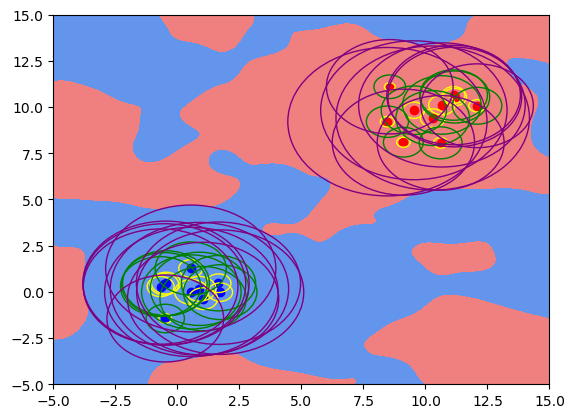

In [6]:
xs = np.linspace(-5, 15, 100)
ys = np.linspace(-5, 15, 100)
x, y = np.meshgrid(xs, ys)

phi_0 = encoder.encode(np.array([0, 0]))
xys_enc = encoder.encode(np.stack([x, y], axis=0))
zs = encoder.inner(phi_c1 - phi_c2, xys_enc)

fig, ax = plt.subplots()
z_max = np.max(np.abs(zs)) + 1
ax.contourf(x, y, zs, levels=[-z_max, 0, z_max], colors=["lightcoral", "cornflowerblue"])
ax.scatter(c1.Xtr[:, 0], c1.Xtr[:, 1], color="blue")
ax.scatter(c2.Xtr[:, 0], c2.Xtr[:, 1], color="red")

# method 1
es1 = []
for x in c1.Xtr:
    eps = get_eps(encoder, x, phi_c1, phi_c2)
    circle = plt.Circle((x[0], x[1]), eps, fill=False, edgecolor="yellow")
    ax.add_patch(circle)
    es1.append(eps)
    
for x in c2.Xtr:
    eps = get_eps(encoder, x, phi_c1, phi_c2)
    circle = plt.Circle((x[0], x[1]), eps, fill=False, edgecolor="yellow")
    ax.add_patch(circle)
    es1.append(eps)

# method 2
es2 = []
for x in c1.Xtr:
    eps = get_eps(encoder, x, phi_c1, phi_c2, method=1)
    circle = plt.Circle((x[0], x[1]), eps, fill=False, edgecolor="green")
    ax.add_patch(circle)
    es2.append(eps)
    
for x in c2.Xtr:
    eps = get_eps(encoder, x, phi_c1, phi_c2, method=1)
    circle = plt.Circle((x[0], x[1]), eps, fill=False, edgecolor="green")
    ax.add_patch(circle)
    es2.append(eps)

    
xs = np.linspace(-5, 15, 100)
ys = np.linspace(-5, 15, 100)
x, y = np.meshgrid(xs, ys)

# actual
es3 = []
for x_ctr in c1.Xtr:
    eps = get_actual_eps(encoder, phi_c1, phi_c2, x_ctr, x, y, zs)
    circle = plt.Circle((x_ctr[0], x_ctr[1]), eps, fill=False, edgecolor="purple")
    ax.add_patch(circle)
    es3.append(eps)
    
for x_ctr in c2.Xtr:
    eps = get_actual_eps(encoder, phi_c1, phi_c2, x_ctr, x, y, zs)
    circle = plt.Circle((x_ctr[0], x_ctr[1]), eps, fill=False, edgecolor="purple")
    ax.add_patch(circle)
    es3.append(eps)
    
es1 = np.array(es1)
es2 = np.array(es2)
es3 = np.array(es3)